# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:3')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.953007
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (640, 640)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes, hw=160))#, l_size_lambda=3)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=100, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:165.91845703125
last losses: [4976.232421875, 0.23584794998168945, 1.084853172302246]
epoch 0|30; total loss:170.09506225585938
last losses: [2.4819977283477783, 0.23232609033584595, 0.6010195016860962]
epoch 0|60; total loss:3.5482141971588135
last losses: [2.880831718444824, 0.2713388502597809, 0.6214086413383484]
epoch 0|90; total loss:3.2056524753570557
last losses: [2.299083948135376, 0.24411499500274658, 0.5828918814659119]
epoch 0|120; total loss:3.02522349357605
last losses: [2.035675287246704, 0.2359268069267273, 0.5526165962219238]
epoch 0|150; total loss:3.0477068424224854
last losses: [1.9701383113861084, 0.23751115798950195, 0.6149725914001465]
epoch 0|180; total loss:2.8632991313934326
last losses: [1.83097505569458, 0.2271563857793808, 0.6191533207893372]
epoch 0|210; total loss:2.7627463340759277
last losses: [2.157538652420044, 0.2810443043708801, 0.8074008226394653]
epoch 0|240; total loss:2.7206623554229736
last losses: [1.7885258197784424, 0.25

epoch 7|30; total loss:1.1769163608551025
last losses: [0.8141900300979614, 0.23573090136051178, 0.28823527693748474]
epoch 7|60; total loss:1.1909815073013306
last losses: [0.6788918972015381, 0.21868999302387238, 0.23292797803878784]
epoch 7|90; total loss:1.2200846672058105
last losses: [0.6647021770477295, 0.1910715252161026, 0.22400231659412384]
epoch 7|120; total loss:1.1937270164489746
last losses: [0.7153944373130798, 0.21076753735542297, 0.31258684396743774]
epoch 7|150; total loss:1.1880358457565308
last losses: [0.7559667229652405, 0.22257019579410553, 0.24260365962982178]
epoch 7|180; total loss:1.2230805158615112
last losses: [0.6446943283081055, 0.2294924259185791, 0.1949109137058258]
epoch 7|210; total loss:1.245184302330017
last losses: [0.8325221538543701, 0.24756017327308655, 0.2594379186630249]
epoch 7|240; total loss:1.2278993129730225
last losses: [0.7311869859695435, 0.19527995586395264, 0.3500632345676422]
epoch 7|270; total loss:1.189340353012085
last losses: [0

epoch 14|30; total loss:0.747657835483551
last losses: [0.3792540431022644, 0.16633421182632446, 0.1638202965259552]
epoch 14|60; total loss:0.7515661716461182
last losses: [0.3548584580421448, 0.17914056777954102, 0.251695454120636]
epoch 14|90; total loss:0.7390937805175781
last losses: [0.3835742175579071, 0.19821807742118835, 0.17051875591278076]
epoch 14|120; total loss:0.729627788066864
last losses: [0.327571839094162, 0.17642921209335327, 0.15752887725830078]
epoch 14|150; total loss:0.7406606674194336
last losses: [0.3532114028930664, 0.2057044506072998, 0.15604723989963531]
epoch 14|180; total loss:0.7509990930557251
last losses: [0.40274500846862793, 0.19667068123817444, 0.15293484926223755]
epoch 14|210; total loss:0.7314260601997375
last losses: [0.460208922624588, 0.19660958647727966, 0.17861098051071167]
epoch 14|240; total loss:0.7880696654319763
last losses: [0.49185293912887573, 0.1964448243379593, 0.1992124617099762]
epoch 14|270; total loss:0.789675235748291
last los

epoch 21|0; total loss:0.01947653852403164
last losses: [0.2376357764005661, 0.18807825446128845, 0.15858206152915955]
epoch 21|30; total loss:0.5229041576385498
last losses: [0.24366360902786255, 0.1862630993127823, 0.14158184826374054]
epoch 21|60; total loss:0.5380794405937195
last losses: [0.17297713458538055, 0.17206263542175293, 0.12004043906927109]
epoch 21|90; total loss:0.5269794464111328
last losses: [0.2404162585735321, 0.1892346441745758, 0.1842852085828781]
epoch 21|120; total loss:0.5307856798171997
last losses: [0.22717559337615967, 0.18135441839694977, 0.15392489731311798]
epoch 21|150; total loss:0.5653024315834045
last losses: [0.2522576153278351, 0.20217543840408325, 0.14360013604164124]
epoch 21|180; total loss:0.5593229532241821
last losses: [0.2312345653772354, 0.1638982892036438, 0.10800214856863022]
epoch 21|210; total loss:0.5525594353675842
last losses: [0.27269959449768066, 0.1845112442970276, 0.14937849342823029]
epoch 21|240; total loss:0.5589062571525574
l

epoch 27|270; total loss:0.45065024495124817
last losses: [0.17413963377475739, 0.1513698399066925, 0.10685449093580246]
epoch 28|0; total loss:0.013412491418421268
last losses: [0.13417167961597443, 0.14629215002059937, 0.12191088497638702]
epoch 28|30; total loss:0.4551849961280823
last losses: [0.15850003063678741, 0.14436659216880798, 0.1267128884792328]
epoch 28|60; total loss:0.4155288636684418
last losses: [0.1322380155324936, 0.16492950916290283, 0.11050790548324585]
epoch 28|90; total loss:0.41212260723114014
last losses: [0.12198331952095032, 0.1426391899585724, 0.08972517400979996]
epoch 28|120; total loss:0.41826707124710083
last losses: [0.14842039346694946, 0.156724750995636, 0.12924259901046753]
epoch 28|150; total loss:0.4245021939277649
last losses: [0.17837345600128174, 0.1919310986995697, 0.14842768013477325]
epoch 28|180; total loss:0.42734119296073914
last losses: [0.16399872303009033, 0.15228669345378876, 0.10965600609779358]
epoch 28|210; total loss:0.41867396235

epoch 34|240; total loss:0.3704940974712372
last losses: [0.14118337631225586, 0.1615815907716751, 0.09357969462871552]
epoch 34|270; total loss:0.4024347960948944
last losses: [0.10136789828538895, 0.1551065891981125, 0.10101084411144257]
epoch 35|0; total loss:0.01150112971663475
last losses: [0.09368284046649933, 0.1552058905363083, 0.09614516794681549]
epoch 35|30; total loss:0.39000290632247925
last losses: [0.10847344994544983, 0.1602659374475479, 0.0886155366897583]
epoch 35|60; total loss:0.3586564362049103
last losses: [0.08443189412355423, 0.121796153485775, 0.08241111040115356]
epoch 35|90; total loss:0.3655073642730713
last losses: [0.10489881038665771, 0.15454518795013428, 0.09532411396503448]
epoch 35|120; total loss:0.36576220393180847
last losses: [0.15265972912311554, 0.16059798002243042, 0.1006273627281189]
epoch 35|150; total loss:0.3596190810203552
last losses: [0.12264421582221985, 0.15236391127109528, 0.09930552542209625]
epoch 35|180; total loss:0.365592628717422

epoch 41|210; total loss:0.3110281527042389
last losses: [0.08271385729312897, 0.14763608574867249, 0.10807180404663086]
epoch 41|240; total loss:0.3172047734260559
last losses: [0.0866607055068016, 0.14980638027191162, 0.09809902310371399]
epoch 41|270; total loss:0.3239135146141052
last losses: [0.08047863841056824, 0.1325584352016449, 0.0894555151462555]
epoch 42|0; total loss:0.013903680257499218
last losses: [0.15060551464557648, 0.16366080939769745, 0.10284407436847687]
epoch 42|30; total loss:0.33217915892601013
last losses: [0.10102269053459167, 0.15123166143894196, 0.1140676885843277]
epoch 42|60; total loss:0.31284278631210327
last losses: [0.09829361736774445, 0.14887960255146027, 0.1049952581524849]
epoch 42|90; total loss:0.29774612188339233
last losses: [0.050410687923431396, 0.11405041813850403, 0.0601998046040535]
epoch 42|120; total loss:0.3078444004058838
last losses: [0.06804364919662476, 0.1493419110774994, 0.09181626886129379]
epoch 42|150; total loss:0.30531409382

epoch 48|150; total loss:0.2706468999385834
last losses: [0.06666252017021179, 0.13546200096607208, 0.08556511998176575]
epoch 48|180; total loss:0.2659110426902771
last losses: [0.05426197499036789, 0.11572906374931335, 0.05974322929978371]
epoch 48|210; total loss:0.2838442027568817
last losses: [0.0895194560289383, 0.14700618386268616, 0.07528099417686462]
epoch 48|240; total loss:0.28389042615890503
last losses: [0.08736883103847504, 0.11982956528663635, 0.09374027699232101]
epoch 48|270; total loss:0.2838843762874603
last losses: [0.07496584951877594, 0.14327511191368103, 0.08412318676710129]
epoch 49|0; total loss:0.007045069709420204
last losses: [0.028339626267552376, 0.12177355587482452, 0.06123889237642288]
epoch 49|30; total loss:0.27015531063079834
last losses: [0.05779218673706055, 0.1244991347193718, 0.07370838522911072]
epoch 49|60; total loss:0.2602084279060364
last losses: [0.05619392544031143, 0.141045480966568, 0.08288710564374924]
epoch 49|90; total loss:0.252288758

epoch 55|90; total loss:0.2423456311225891
last losses: [0.04955919831991196, 0.13850829005241394, 0.0786847397685051]
epoch 55|120; total loss:0.23927202820777893
last losses: [0.04504351317882538, 0.122420534491539, 0.07664957642555237]
epoch 55|150; total loss:0.23926106095314026
last losses: [0.05291876941919327, 0.145335391163826, 0.08201657235622406]
epoch 55|180; total loss:0.23137032985687256
last losses: [0.04031982272863388, 0.12689010798931122, 0.07739250361919403]
epoch 55|210; total loss:0.23759032785892487
last losses: [0.0637253075838089, 0.12885941565036774, 0.07744508236646652]
epoch 55|240; total loss:0.2369898110628128
last losses: [0.03969387337565422, 0.13387136161327362, 0.0653783455491066]
epoch 55|270; total loss:0.23205320537090302
last losses: [0.0423305481672287, 0.09479040652513504, 0.08295533061027527]
epoch 56|0; total loss:0.008259561844170094
last losses: [0.043915558606386185, 0.11657917499542236, 0.08729210495948792]
epoch 56|30; total loss:0.247562870

epoch 62|30; total loss:0.21200761198997498
last losses: [0.04544936865568161, 0.12655790150165558, 0.07287514954805374]
epoch 62|60; total loss:0.21371446549892426
last losses: [0.037101488560438156, 0.10560569167137146, 0.0729307010769844]
epoch 62|90; total loss:0.21134015917778015
last losses: [0.030695822089910507, 0.12611325085163116, 0.0658583790063858]
epoch 62|120; total loss:0.2018638700246811
last losses: [0.026933280751109123, 0.08682117611169815, 0.0762319415807724]
epoch 62|150; total loss:0.20073547959327698
last losses: [0.026154134422540665, 0.08529189974069595, 0.06353627890348434]
epoch 62|180; total loss:0.20306798815727234
last losses: [0.021822571754455566, 0.1057078167796135, 0.09078150242567062]
epoch 62|210; total loss:0.20900113880634308
last losses: [0.04015735536813736, 0.11786530911922455, 0.06988213211297989]
epoch 62|240; total loss:0.2026888132095337
last losses: [0.03204178810119629, 0.0923716351389885, 0.04758283868432045]
epoch 62|270; total loss:0.20

epoch 68|270; total loss:0.19204957783222198
last losses: [0.027364537119865417, 0.10380047559738159, 0.06504000723361969]
epoch 69|0; total loss:0.005375992506742477
last losses: [0.017951564863324165, 0.09353258460760117, 0.049795616418123245]
epoch 69|30; total loss:0.18644601106643677
last losses: [0.0258768443018198, 0.08771760016679764, 0.06528899073600769]
epoch 69|60; total loss:0.19228766858577728
last losses: [0.021431520581245422, 0.09818615019321442, 0.06996918469667435]
epoch 69|90; total loss:0.17968642711639404
last losses: [0.02236124873161316, 0.09640143811702728, 0.05434790998697281]
epoch 69|120; total loss:0.17690831422805786
last losses: [0.018988944590091705, 0.0795804113149643, 0.05948508530855179]
epoch 69|150; total loss:0.1815977692604065
last losses: [0.02048659510910511, 0.1019386574625969, 0.06150604039430618]
epoch 69|180; total loss:0.1733909696340561
last losses: [0.013290849514305592, 0.10735079646110535, 0.05956543982028961]
epoch 69|210; total loss:0.

epoch 75|210; total loss:0.16319939494132996
last losses: [0.021200120449066162, 0.08276508748531342, 0.06435038149356842]
epoch 75|240; total loss:0.16349388659000397
last losses: [0.011275142431259155, 0.08223527669906616, 0.05103185027837753]
epoch 75|270; total loss:0.160143181681633
last losses: [0.017885521054267883, 0.08600754290819168, 0.06637947261333466]
epoch 76|0; total loss:0.00415080226957798
last losses: [0.007553571835160255, 0.06560065597295761, 0.051369838416576385]
epoch 76|30; total loss:0.1594718098640442
last losses: [0.02539856731891632, 0.09007281810045242, 0.06721232831478119]
epoch 76|60; total loss:0.1567128449678421
last losses: [0.010783564299345016, 0.08857911825180054, 0.07465256750583649]
epoch 76|90; total loss:0.15845447778701782
last losses: [0.010961265303194523, 0.06801573187112808, 0.046151868999004364]
epoch 76|120; total loss:0.15037189424037933
last losses: [0.019351376220583916, 0.07869260758161545, 0.04974646121263504]
epoch 76|150; total loss

epoch 82|150; total loss:0.14068087935447693
last losses: [0.013695567846298218, 0.06342670321464539, 0.05192791670560837]
epoch 82|180; total loss:0.16593492031097412
last losses: [0.03796997666358948, 0.0877520814538002, 0.07893440872430801]
epoch 82|210; total loss:0.24577556550502777
last losses: [0.09285955876111984, 0.10716307908296585, 0.07037928700447083]
epoch 82|240; total loss:0.23425047099590302
last losses: [0.03398844227194786, 0.09891131520271301, 0.085938960313797]
epoch 82|270; total loss:0.20326027274131775
last losses: [0.050607599318027496, 0.08998207747936249, 0.04903208464384079]
epoch 83|0; total loss:0.04195813462138176
last losses: [0.8044010400772095, 0.19022411108016968, 0.26411888003349304]
epoch 83|30; total loss:0.9124242663383484
last losses: [0.4399847388267517, 0.15580059587955475, 0.14769253134727478]
epoch 83|60; total loss:0.632474422454834
last losses: [0.26354801654815674, 0.12596744298934937, 0.08614103496074677]
epoch 83|90; total loss:0.50763082

epoch 89|60; total loss:0.11248603463172913
last losses: [0.03759758919477463, 0.05900823324918747, 0.05033218115568161]
epoch 89|90; total loss:0.10882444679737091
last losses: [0.0030175705906003714, 0.07327588647603989, 0.04613137245178223]
epoch 89|120; total loss:0.11000663042068481
last losses: [0.0037629734724760056, 0.05286424234509468, 0.04056081920862198]
epoch 89|150; total loss:0.12380769103765488
last losses: [0.022161755710840225, 0.06530401110649109, 0.05218584090471268]
epoch 89|180; total loss:0.11225779354572296
last losses: [0.011670074425637722, 0.05858822539448738, 0.06350240856409073]
epoch 89|210; total loss:0.1146964281797409
last losses: [0.0022915774025022984, 0.051763586699962616, 0.03534006327390671]
epoch 89|240; total loss:0.11539654433727264
last losses: [0.009081463329494, 0.05236044526100159, 0.033100053668022156]
epoch 89|270; total loss:0.1114758849143982
last losses: [0.00270644947886467, 0.04926694929599762, 0.04857280105352402]
epoch 90|0; total lo

epoch 95|270; total loss:0.12173646688461304
last losses: [0.01774301752448082, 0.06042207404971123, 0.04883778467774391]
epoch 96|0; total loss:0.004629067145287991
last losses: [0.02416440099477768, 0.0614091120660305, 0.053298503160476685]
epoch 96|30; total loss:0.12841524183750153
last losses: [0.01185767911374569, 0.07012072205543518, 0.06975734233856201]
epoch 96|60; total loss:0.11926738917827606
last losses: [0.004825104959309101, 0.04694618657231331, 0.04090604931116104]
epoch 96|90; total loss:0.11447819322347641
last losses: [0.007383434101939201, 0.05950894206762314, 0.055039919912815094]
epoch 96|120; total loss:0.11386992037296295
last losses: [0.010451151989400387, 0.062492735683918, 0.04229769855737686]
epoch 96|150; total loss:0.1193641722202301
last losses: [0.015890832990407944, 0.07373028248548508, 0.04903307184576988]
epoch 96|180; total loss:0.12171053141355515
last losses: [0.013174078427255154, 0.0628635510802269, 0.0428941510617733]
epoch 96|210; total loss:0.

In [19]:
torch.save(net, 'centernet_resnet34_640.pth')

# Quality

## Postprocessing and visualization

In [20]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [21]:
net = torch.load('centernet_resnet34_640.pth')

In [22]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet34Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [23]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to(device)).cpu()    
    yp = net(x[None].to(device), return_objects=True).cpu()

class 0 heatmap


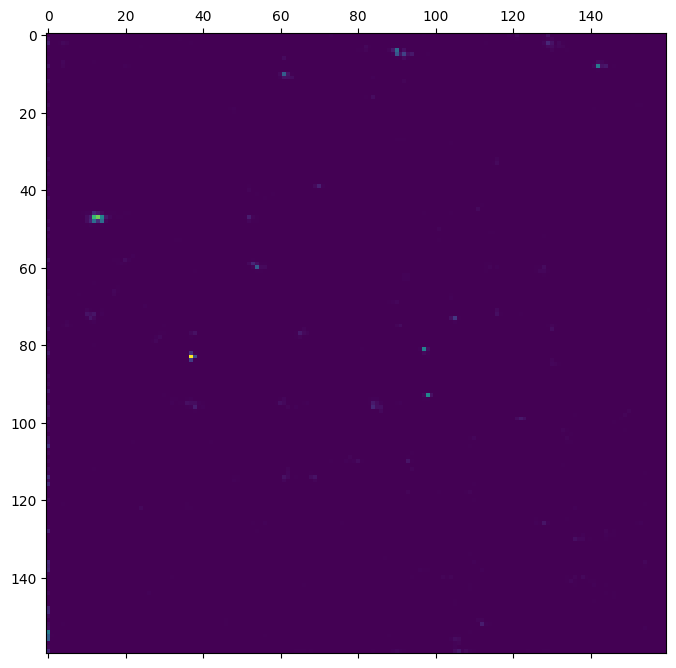

class 1 heatmap


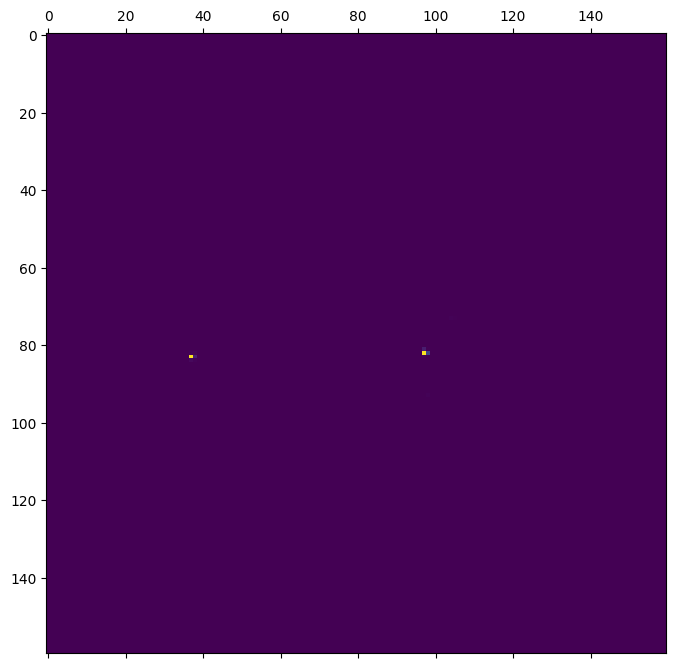

w_heatmap


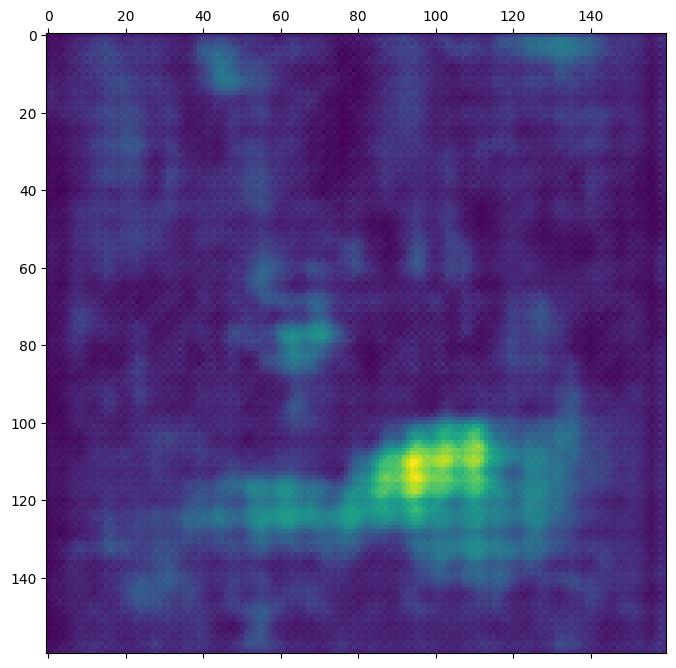

h heatmap


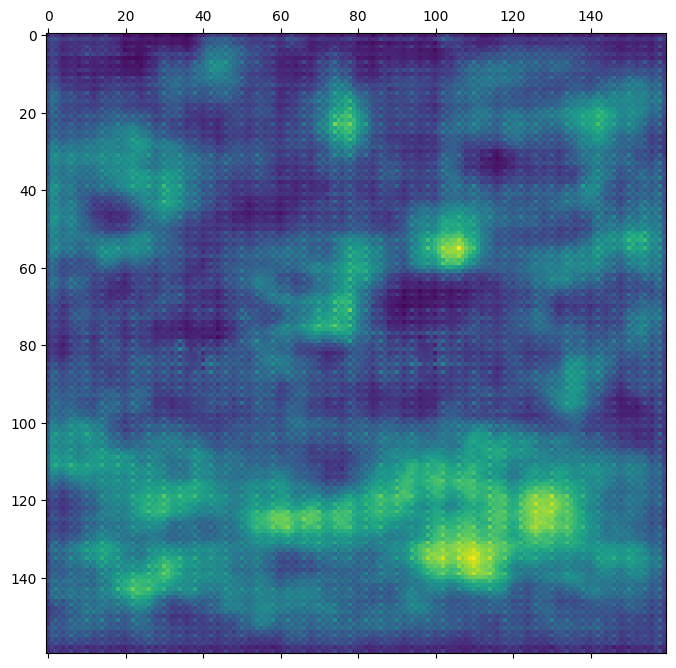

In [24]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [25]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


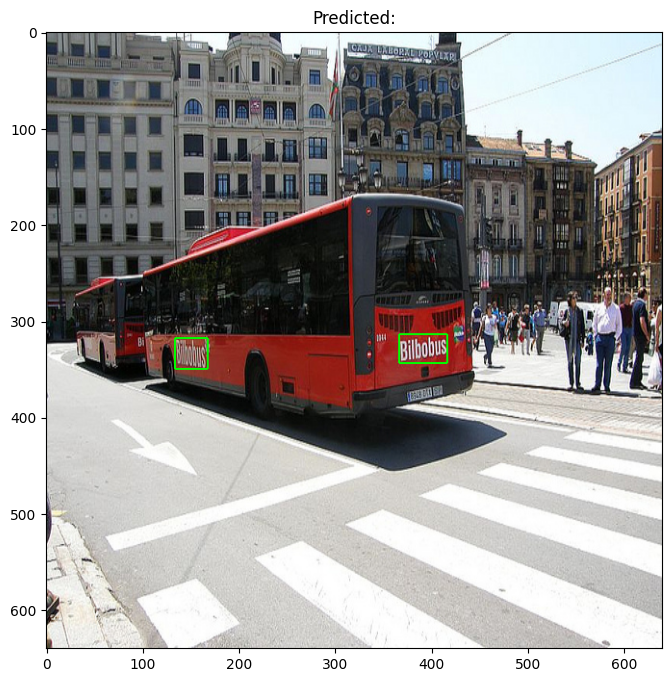

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


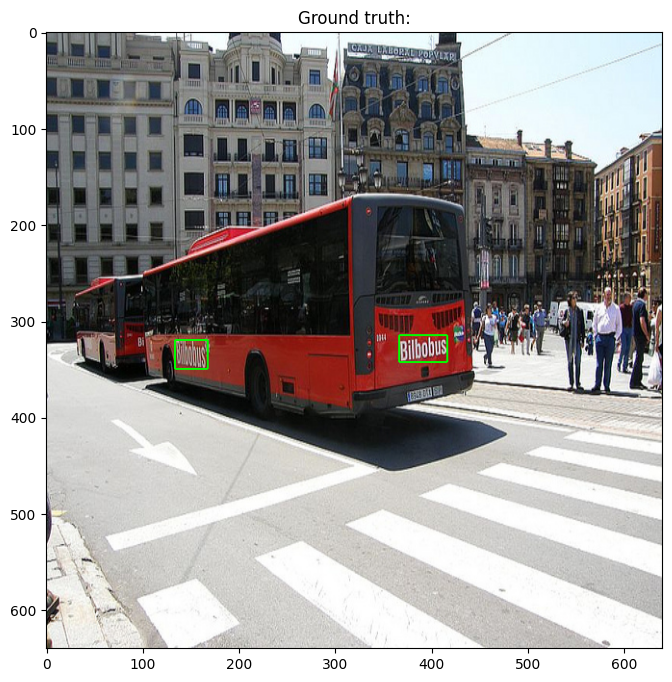

In [26]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [27]:
print(yp[0][:2], y[:2])

tensor([[328.6744, 391.8059,  30.3502,  49.7171,   1.0000,   0.9762],
        [334.1922, 151.3318,  33.3058,  34.7506,   1.0000,   0.9750]]) tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000]])


## Saving to json

In [28]:
#net = torch.load('centernet_resnet34_640.pth')

In [29]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:26<00:00, 51.58it/s]


Loading and preparing results...     
DONE (t=0.22s)
Итоговый скор AP на val: 0.3611239531751586


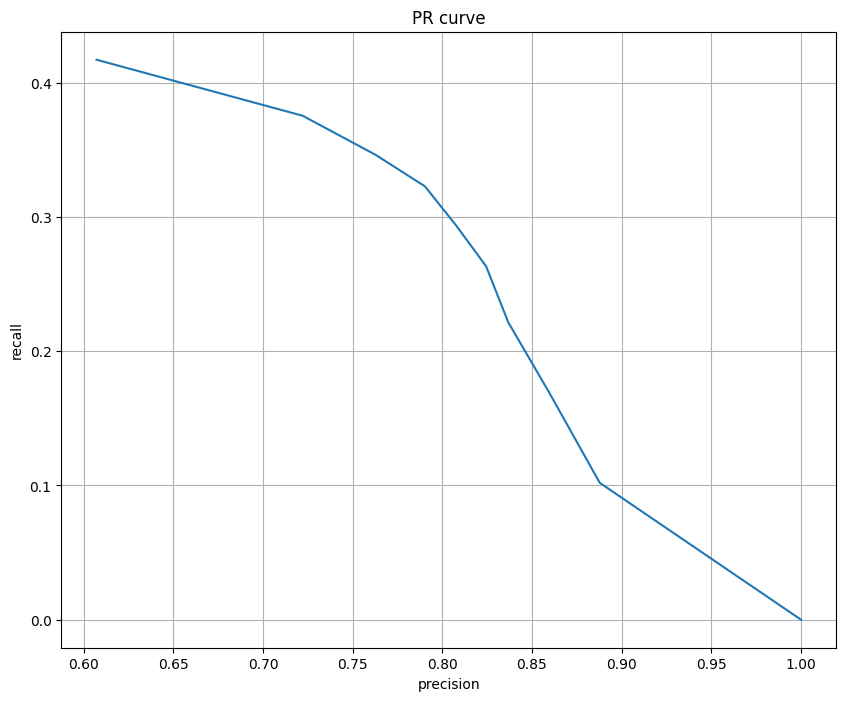

In [30]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [31]:
n_obj

10601

In [ ]:
rec